# CORD-19 Explore dataset
In general, this jupyter notebook is designated to explore the CORD19 dataset: 
https://datadryad.org/stash/dataset/doi:10.5061/dryad.vmcvdncs0

First, relevant packages must be imported to the Notebook.

In [1]:
import numpy as np
import pandas as pd
import csv
import ast
import collections
import matplotlib.pyplot as plt
import Levenshtein as lev
from fuzzywuzzy import fuzz 
import datetime
import matplotlib.pyplot as plt
import re
from urllib.parse import urlparse
from collections import Counter

In [2]:
CORD19_CSV = pd.read_csv('../data/cord-19/CORD19_software_mentions.csv')

Show the head of the dataset to inspect all columns and obtain a broad overview. 

In [3]:
CORD19_CSV.head(20)

,paper_id,doi,title,source_x,license,publish_time,journal,url,software
0,00006903b396d50cc0037fed39916d57d50ee801,NaN,Urban green space and happiness in developed c...,ArXiv,arxiv,2021-01-04,NaN,https://arxiv.org/pdf/2101.00807v1.pdf,['Google Street View']
1,0000fcce604204b1b9d876dc073eb529eb5ce305,10.1016/j.regg.2021.01.002,La Geriatría de Enlace con residencias en la é...,Elsevier; PMC,els-covid,2021-01-13,Rev Esp Geriatr Gerontol,https://api.elsevier.com/content/article/pii/S...,['SEGG']
2,000122a9a774ec76fa35ec0c0f6734e7e8d0c541,10.1016/j.rec.2020.08.002,Impact of COVID-19 on ST-segment elevation myo...,Elsevier; Medline; PMC,no-cc,2020-09-08,Rev Esp Cardiol (Engl Ed),https://api.elsevier.com/content/article/pii/S...,"['STATA', 'IAMCEST']"
3,0001418189999fea7f7cbe3e82703d71c85a6fe5,10.1016/j.vetmic.2006.11.026,Absence of surface expression of feline infect...,Elsevier; Medline; PMC,no-cc,2007-03-31,Vet Microbiol,https://www.sciencedirect.com/science/article/...,['SPSS']
4,00033d5a12240a8684cfe943954132b43434cf48,10.3390/v12080849,Detection of Severe Acute Respiratory Syndrome...,Medline; PMC,cc-by,2020-08-04,Viruses,https://www.ncbi.nlm.nih.gov/pubmed/32759673/;...,"['R', 'MassARRAY Typer Analyzer']"
5,00035ac98d8bc38fbca02a1cc957f55141af67c0,10.3389/fpsyt.2020.559701,The Psychological Pressures of Breast Cancer P...,Medline; PMC,cc-by,2020-12-15,Front Psychiatry,https://doi.org/10.3389/fpsyt.2020.559701; htt...,"['Wechat', 'SPSS Statistics']"
6,00039b94e6cb7609ecbddee1755314bcfeb77faa,10.1111/j.1365-2249.2004.02415.x,Plasma inflammatory cytokines and chemokines i...,Medline; PMC,bronze-oa,2004-04-01,Clinical & Experimental Immunology,https://onlinelibrary.wiley.com/doi/pdfdirect/...,['Statistical Package for Social Sciences (SPS...
7,0004456994f6c1d5db7327990386d33c01cff32a,10.1186/1471-2334-10-8,Seasonal influenza risk in hospital healthcare...,PMC,cc-by,2010-01-12,BMC Infect Dis,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2...,"['STATA', 'STATA', 'Statacorp']"
8,00073cb65dd2596249230fab8b15a71c4a135895,10.1086/605034,Risk Parameters of Fulminant Acute Respiratory...,Medline; PMC,no-cc,2009-08-01,J Infect Dis,https://doi.org/10.1086/605034; https://www.nc...,"['SPSS', 'SPSS']"
9,0007f972812bb45abbe5b0edf8db5359d49c23eb,10.1186/s42234-020-00057-1,The role of nicotinic receptors in SARS-CoV-2 ...,Medline; PMC,cc-by,2020-10-28,Bioelectron Med,https://www.ncbi.nlm.nih.gov/pubmed/33292872/;...,"['geNorm', 'GraphPad Prism', 'GraphPad', 'Cell..."


### General check of the dataframe

First, of all it is interesting to investigate how many NaN are contained within the DataFrame. 

In [4]:
CORD19_CSV.isnull().sum().sum()

12476

How are the NaNs distributed between the columns of the DataFrame? 

In [5]:
def count_nan_per_column(df):
    """ This function counts the NaNs per column of the received dataframe 
    and returns a dataframe containing a column listing the number of NaNs.
    """
    col_num = []
    col_name = []
    for i in df: 
        col_num.append(df[i].isnull().sum())
    col_names = df.columns
    df_joined =  pd.DataFrame(col_num, col_names)
    df_joined.columns = ['NaNs']
    return df_joined

In [6]:
df_NaNs = count_nan_per_column(CORD19_CSV)
df_NaNs

,NaNs
paper_id,0
doi,3144
title,0
source_x,0
license,0
publish_time,0
journal,9332
url,0
software,0


For further analysis, it is important to obey that the columns "doi" and "journal" contain NaNs.

In [7]:
CORD19_CSV.fillna('').astype(str).apply(lambda x:x.str.len()).mean()

paper_id         40.000000
doi              24.133883
title           102.960064
source_x         12.139758
license           5.899985
publish_time      9.930508
journal          15.316212
url             106.520155
software         83.598324
dtype: float64

For further analysis, the average length of the titles is long and can be seen as descriptive.

The column publish_time is converted to the datetime format. 

In [8]:
CORD19_CSV['publish_time']=pd.to_datetime(CORD19_CSV.publish_time)

In [9]:
#Indicate corrupted csv
#paper_id -> check integrity with base 16 check ? 
#doi -> Regex check ? 
#title -> check exshow existence of covid, corona in title
#source_x -> show most used source_x
#license -> show most used license
#publish_time -> check how many rows are before 2020 and after
#journal -> show must used journal 

### Dedicated analysis based on columns

Create own series for each row.

In [10]:
paper_id = CORD19_CSV.paper_id
doi = CORD19_CSV.doi
title = CORD19_CSV.title
source_x = CORD19_CSV.source_x
license = CORD19_CSV.license
publish_time= CORD19_CSV.publish_time
journal = CORD19_CSV.journal
url = CORD19_CSV.url

### Checking the column "paper_id"

First, checking the integrity of the series paper_id. It should be be obvious that each row has an unique ID which is not shared with another row. 

In [11]:
paper_id_counted = paper_id.value_counts()
paper_id_counted

0ed3c6a5559cd73307184f51fc53ccc76da559bc    3
c89f86cdd9d41eeec127cc0b03990c52888a9635    2
46b053c7126c1603101f46e4bb6e411f790a45fc    2
dd74a3a343529174fe7c6485723cf2d5911c18ed    2
0831fe32280e46ba8d5c1a9456111e1e009863ac    2
                                           ..
faa0a9a736c193b04e0d7fba6dd821cd07bb3632    1
f60cc2627d2f9036b00a98fea3733e6253b012eb    1
ff7d49ac4008f60ef9c5a437e0d504dcefd1246f    1
e86d1edc11dd72c3c9a669869988c26493086e0e    1
e108ffd04835cea48915ffb3b878be19d5d928f4    1
Name: paper_id, Length: 77436, dtype: int64

The first finding linked to the column paper_id is that this column does not soley contain unique ID's. There's definitely rows which share ID's. For this, the exact number of shared ID's need to be found. 

In [12]:
def find_shared_values(col):
    """ This function checks columns for shared values and deducts NaNs
    """
    col_shared = len(col) - len(col.value_counts())
    col_shared = col_shared - col.isnull().sum()
    return col_shared

In [13]:
paper_id_shared_ids_num = find_shared_values(paper_id)    
paper_id_shared_ids_num

12

The column contains 12 shared ID's with even one used three times. 

In [14]:
paper_id_counted.head(paper_id_shared_ids_num)

0ed3c6a5559cd73307184f51fc53ccc76da559bc    3
c89f86cdd9d41eeec127cc0b03990c52888a9635    2
46b053c7126c1603101f46e4bb6e411f790a45fc    2
dd74a3a343529174fe7c6485723cf2d5911c18ed    2
0831fe32280e46ba8d5c1a9456111e1e009863ac    2
ff40e6b44e151e42a54227e255a88d0c0c104876    2
5d6678f81812464543b367e7de138e23b3483ed1    2
36e2047d1674c3095617f3eb97f9f61e48989dfe    2
d1dde1df11f93e8eae0d0b467cd0455afdc5b98c    2
5d0d0bd116976e1412c10a84902894999df4a342    2
ec7d3038b8912a9fc92f4d02a2c30d566d4d0a93    2
41dbcc06adc978af32a2c10e1aa6bef58646ed4c    1
Name: paper_id, dtype: int64

Check if the dataset contains only duplicates for the column paper_id or for whole DataFrame rows. Therefore, the function collect_rows_of_df will support the process. 

In [15]:
#Method receiving string and dataframe which returns double or tripple dataframe to append 
def collect_rows_of_df(df,column,st):
    """This function receives a dataframe, a column contained within a dataframe 
    and a string which can be found within the column. 
    Then, the string is compared to the whole column and.
    When a match is found, the corresponding rows are returned as a dataframe. 
    """
    subset = df[df[column] == st]
    return subset

Collecting rows which share their paper_id.

In [16]:
x = 0 
shared_paper_id_df = pd.DataFrame(columns=['paper_id','doi','title','source_x','license','publish_time','journal','url','software'])
while x < paper_id_shared_ids_num:
    shared_paper_id_df = shared_paper_id_df.append(collect_rows_of_df(CORD19_CSV, 'paper_id', paper_id_counted.index[x]))
    x= x+1
shared_paper_id_df

,paper_id,doi,title,source_x,license,publish_time,journal,url,software
4466,0ed3c6a5559cd73307184f51fc53ccc76da559bc,10.1016/j.jinf.2020.02.019,Simulating and forecasting the cumulative conf...,Elsevier; Medline; PMC,no-cc,2020-02-26,J Infect,https://doi.org/10.1016/j.jinf.2020.02.019; ht...,"['SAS', 'NLIA', 'NLIA', 'SAS', 'SAS', 'NLIA', ..."
4467,0ed3c6a5559cd73307184f51fc53ccc76da559bc,10.1016/j.jinf.2020.02.020,Novel coronavirus disease (Covid-19): The firs...,Elsevier; Medline; PMC,els-covid,2020-05-31,Journal of Infection,https://www.sciencedirect.com/science/article/...,"['SAS', 'NLIA', 'NLIA', 'SAS', 'SAS', 'NLIA', ..."
4468,0ed3c6a5559cd73307184f51fc53ccc76da559bc,10.1016/j.jinf.2020.02.011,Chinese medical personnel against the 2019-nCoV,Elsevier; Medline; PMC,els-covid,2020-05-31,Journal of Infection,https://api.elsevier.com/content/article/pii/S...,"['SAS', 'NLIA', 'NLIA', 'SAS', 'SAS', 'NLIA', ..."
60796,c89f86cdd9d41eeec127cc0b03990c52888a9635,10.1101/2020.11.07.372938,A low power flexible dielectric barrier discha...,BioRxiv,biorxiv,2020-11-09,bioRxiv,https://doi.org/10.1101/2020.11.07.372938,"['ImageJ', 'ImageJ', 'Sterlis®', 'Sterlis®']"
60797,c89f86cdd9d41eeec127cc0b03990c52888a9635,NaN,A low power flexible dielectric barrier discha...,ArXiv,arxiv,2020-11-08,NaN,https://arxiv.org/pdf/2011.03898v1.pdf,"['ImageJ', 'ImageJ', 'Sterlis®', 'Sterlis®']"
21299,46b053c7126c1603101f46e4bb6e411f790a45fc,NaN,The Interplay of Demographic Variables and Soc...,ArXiv,arxiv,2021-01-06,NaN,https://arxiv.org/pdf/2101.02113v1.pdf,"['Unacast', 'Unacast']"
21300,46b053c7126c1603101f46e4bb6e411f790a45fc,NaN,The Interplay of Demographic Variables and Soc...,Medline; PMC,cc-by-nc-sa,2021-01-06,ArXiv,https://www.ncbi.nlm.nih.gov/pubmed/33442559/,"['Unacast', 'Unacast']"
67078,dd74a3a343529174fe7c6485723cf2d5911c18ed,NaN,Models for COVID-19 Pandemic: A Comparative An...,PMC,cc-by,2020-09-21,ArXiv,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,"['PatchSim', 'Landscan', 'Landscan', 'PatchSim..."
67079,dd74a3a343529174fe7c6485723cf2d5911c18ed,NaN,Models for COVID-19 Pandemic: A Comparative An...,ArXiv,arxiv,2020-09-21,NaN,https://arxiv.org/pdf/2009.10014v1.pdf,"['PatchSim', 'Landscan', 'Landscan', 'PatchSim..."
2447,0831fe32280e46ba8d5c1a9456111e1e009863ac,NaN,A trial emulation approach for policy evaluati...,ArXiv,arxiv,2020-11-11,NaN,https://arxiv.org/pdf/2011.05826v1.pdf,"['NYT Tracker', 'NYT Tracker']"


Besides software, the paper_id duplicates have variations among all other columns which means that the same paper_id was used for different papers. 

### Checking the column "doi"

Each paper in this dataset should have an unique doi because duplicates are skewing the analysis and potential outcomes. 

In [17]:
doi_counted = doi.value_counts()
doi_counted

10.31729/jnma.5498                  2
10.1016/j.dsx.2020.04.012           2
10.1016/b978-012369454-6/50066-2    1
10.1371/journal.pone.0146404        1
10.1136/bmjopen-2019-036098         1
                                   ..
10.1016/j.jaci.2008.10.007          1
10.1186/s12879-018-3662-z           1
10.1155/2018/2514901                1
10.1016/j.cmi.2017.05.027           1
10.1021/acs.jproteome.0c00553       1
Name: doi, Length: 74302, dtype: int64

In [18]:
doi_shared_dois_num = find_shared_values(doi)    
doi_shared_dois_num

2

The column "doi" contains two entries which share a doi. 

In [19]:
doi_counted.head(doi_shared_dois_num)

10.31729/jnma.5498           2
10.1016/j.dsx.2020.04.012    2
Name: doi, dtype: int64

For this, it needs to be explored how the shared dois are in relation to each other based on their row. 

In [20]:
x = 0 
shared_doi_df = pd.DataFrame(columns=['paper_id','doi','title','source_x','license','publish_time','journal','url','software'])
while x < doi_shared_dois_num:
    shared_doi_df  = shared_doi_df.append(collect_rows_of_df(CORD19_CSV, 'doi', doi_counted.index[x]))
    x= x+1
shared_doi_df

,paper_id,doi,title,source_x,license,publish_time,journal,url,software
38600,80273c63683cad57323802542cfdcfcd76c805bf,10.31729/jnma.5498,Mental Wellbeing during the Lockdown Period fo...,PMC,cc-by,2020-10-31,JNMA J Nepal Med Assoc,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,['SPSS']
42407,8cab7532249cedf3815d4dada6400390a1f8a28a,10.31729/jnma.5498,Interpersonal Violence during the COVID-19 Loc...,PMC,cc-by,2020-10-31,JNMA J Nepal Med Assoc,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,"['SPSS', 'WHO']"
16564,36e2047d1674c3095617f3eb97f9f61e48989dfe,10.1016/j.dsx.2020.04.012,Artificial Intelligence (AI) applications for ...,PMC,no-cc,2020-04-14,Diabetes Metab Syndr,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,"['Scopus', 'Google Scholar', 'Scopus', 'Google..."
16565,36e2047d1674c3095617f3eb97f9f61e48989dfe,10.1016/j.dsx.2020.04.012,Artificial Intelligence (AI) applications for ...,Elsevier,els-covid,2020-08-31,Diabetes & Metabolic Syndrome: Clinical Resear...,https://api.elsevier.com/content/article/pii/S...,"['Scopus', 'Google Scholar', 'Scopus', 'Google..."


The first match of doi is already know for sharing paper_id's. 
For the shared doi, there is an interesting occurence because the algorihtm which created the dataset outputed two distinct outcomes for the column software. 

### Checking the column "title"

Next, the column title will be investigated to produce insights. 

In [21]:
title_counted = title.value_counts()
title_counted

Full Issue PDF                                                                                                                                                                                                  15
Posters                                                                                                                                                                                                          8
Poster Presentations                                                                                                                                                                                             8
Poster Sessions                                                                                                                                                                                                  7
Poster Session Abstracts                                                                                                                                    

In [22]:
title_shared_titles_num = find_shared_values(title)    
title_shared_titles_num

870

Compared to the other duplicates, there are much more shared titles. 

In [23]:
if title_shared_titles_num > 20:
    head_for_title = 40
else:
    head_for_title = title_shared_titles_num
title_counted.head(head_for_title)

Full Issue PDF                                                                                  15
Posters                                                                                          8
Poster Presentations                                                                             8
Poster Sessions                                                                                  7
Poster Session Abstracts                                                                         7
Scientific Abstracts                                                                             6
Physicians Poster Sessions                                                                       6
Infectieziekten                                                                                  5
Abstract                                                                                         5
Abstracts cont.                                                                                  5
NEWS      

The root for such a high amount of title duplicates might be founded by various reasons. At least for this selection, the paper has a poor naming which means that they might be published without a name and got assigned a placeholder. Furthermore, this selection has a weak linkage to COVID related research. Based on the titles, the shown selection contains more none COVID related publications than research in relation to COVID.  

The column strings contains words which can be investigated by matching to certain substrings. Therefore, the following function will support the process. 

In [24]:
def check_column_for_string(df, col, st):
    """Function which checks matches of substrings in the whole column and returns a dataframe containing substring matches
    """
    df_match = df.loc[df[col].str.contains(st, case=False)]
    return df_match

To inspect the density of COVID related publications, the column title will be checked for common words: 

<ul>
  <li>Covid</li>
  <li>Corona</li>
  <li>Lockdown</li>
  <li>SARS</li>
</ul>

In [25]:
matched_df_covid = check_column_for_string(CORD19_CSV, 'title', 'covid')
matched_df_corona = check_column_for_string(CORD19_CSV, 'title', 'corona')
matched_df_lockdown = check_column_for_string(CORD19_CSV, 'title', 'lockdown')
matched_df_sars = check_column_for_string(CORD19_CSV, 'title', 'sars')

In [26]:
sum_covid_related = len(matched_df_covid) + len(matched_df_corona) + len(matched_df_lockdown) + len(matched_df_sars)
sum_covid_related

40233

The sum may contain an overlap of the checked substrings which needs to be deducted. 

In [27]:
matched_df_covid_medical = matched_df_covid.append(matched_df_corona)
matched_df_covid_medical.append(matched_df_lockdown)
matched_df_covid_medical.append(matched_df_sars)
matched_df_covid_medical_len = len(matched_df_covid_medical)
matched_df_covid_medical_len

30982

To inspect potential effects of COVID to the society, the column title will be checked additional words:

<ul>
  <li>Econmic</li>
  <li>Social</li>
</ul>

In [28]:
matched_df_economic = check_column_for_string(CORD19_CSV, 'title', 'economic')
matched_df_social = check_column_for_string(CORD19_CSV, 'title', 'social')

In [29]:
len(matched_df_economic)

465

In [30]:
len(matched_df_social)

1542

Compared to the size of the dataset, the potential covid impacts on the society have less importance. 

In [31]:
matched_df_society = matched_df_economic.append(matched_df_social)
matched_df_society_len = len(matched_df_society) 
matched_df_society_len

2007

There might be an overlap between the covid related dataframe and the dataframe addressing covid impacts on the society. 

In [32]:
combined_df_fields = matched_df_society.append(matched_df_covid_medical)
dif_len_fields = len(matched_df_covid_medical) + len(matched_df_society) - len(combined_df_fields) 
dif_len_fields

0

The both set up fields do not have any overlap. Consequently, it is possible that the society field is not linked to COVID related subjects and investigates distant fields. 

### Checking the column "source_x"

For publishing purposes, the source of the papers will be inspected.

In [33]:
source_x_counted = source_x.value_counts()
source_x_counted

Medline; PMC                           32777
Elsevier; Medline; PMC                 15500
PMC                                    15103
MedRxiv; WHO                            4760
ArXiv                                   3115
Elsevier; PMC                           1831
BioRxiv; WHO                            1252
BioRxiv                                  796
MedRxiv                                  367
MedRxiv; Medline; PMC; WHO               331
Medline; PMC; WHO                        285
BioRxiv; Medline; PMC; WHO               278
MedRxiv; Medline; WHO                    152
BioRxiv; MedRxiv                         149
BioRxiv; Medline; WHO                    145
Elsevier                                 135
ArXiv; Medline; PMC                      123
Elsevier; Medline; PMC; WHO              115
ArXiv; Elsevier; Medline; PMC             62
BioRxiv; MedRxiv; WHO                     51
BioRxiv; Medline; PMC                     27
ArXiv; Medline                            23
BioRxiv; M

Most of the publications have various  and shared publishers.

In [34]:
len_source_x_counted = len(source_x_counted)

Thusly, it needs to be considered which sources are responsible for the most publications. 

In [35]:
i = 0
while i < len_source_x_counted:
    source_x_counted.index.values[i] = source_x_counted.index.values[i].replace(';', '')
    i= i+1
source_x_counted

Medline PMC                        32777
Elsevier Medline PMC               15500
PMC                                15103
MedRxiv WHO                         4760
ArXiv                               3115
Elsevier PMC                        1831
BioRxiv WHO                         1252
BioRxiv                              796
MedRxiv                              367
MedRxiv Medline PMC WHO              331
Medline PMC WHO                      285
BioRxiv Medline PMC WHO              278
MedRxiv Medline WHO                  152
BioRxiv MedRxiv                      149
BioRxiv Medline WHO                  145
Elsevier                             135
ArXiv Medline PMC                    123
Elsevier Medline PMC WHO             115
ArXiv Elsevier Medline PMC            62
BioRxiv MedRxiv WHO                   51
BioRxiv Medline PMC                   27
ArXiv Medline                         23
BioRxiv Medline                       13
MedRxiv Medline PMC                   11
ArXiv PMC       

In [36]:
i = 0
df_source_holder = pd.DataFrame(columns=['source_x','counts'])
while i < len_source_x_counted:
    helper = source_x_counted.index[i].split()
    for x in helper:
        data = {'source_x': x, 'counts': source_x_counted[i]}
        df_source_holder = df_source_holder.append(pd.DataFrame([data]))
    i = i + 1

df_source_holder = df_source_holder.reset_index()
df_source_holder = df_source_holder.drop(labels=["index"], axis=1)
df_source_holder

,source_x,counts
0,Medline,32777
1,PMC,32777
2,Elsevier,15500
3,Medline,15500
4,PMC,15500
...,...,...
91,PMC,1
92,WHO,1
93,BioRxiv,1
94,MedRxiv,1


The dataframe above contains the counts per each source which must be summed up properly.

In [37]:
len_df_source_holder = len(df_source_holder)
sources_series = df_source_holder['source_x'].value_counts()
len_sources_series = len(sources_series.index)

df_total_counts = pd.DataFrame(columns=['total_counts'], index = sources_series.index )
df_total_counts['total_counts'] = 0

i = 0
while i < len_sources_series :
    x = 0
    while x < len_df_source_holder:
        if df_source_holder['source_x'][x] == sources_series.index[i]:
            df_total_counts['total_counts'][sources_series.index[i]] = df_total_counts['total_counts'][sources_series.index[i]] + df_source_holder['counts'][x]
        x = x + 1
    i = i + 1

df_total_counts.sort_values(by="total_counts", ascending=False)

,total_counts
PMC,66472
Medline,49864
Elsevier,17660
WHO,7388
MedRxiv,5836
ArXiv,3340
BioRxiv,2724


In overall, PMC and Medline participate mostly as a source within this dataset. It is important to obey that several sources can contribute to one publication. 

### Checking the column "license"

For the column license, it might be interesting to create an overview about all used licenses. 

In [38]:
license_counted = license.value_counts()
license_counted

no-cc          29395
cc-by          23384
els-covid       7374
medrxiv         5401
arxiv           3141
cc-by-nc        2947
biorxiv         2325
cc-by-nc-nd     1860
green-oa         385
bronze-oa        352
cc-by-nc-sa      349
cc0              312
cc-by-nd         130
hybrid-oa         71
gold-oa           20
cc-by-sa           2
Name: license, dtype: int64

For the publications, there are several licenses used. 

### Checking the column "publish_time"

For the column publish_time, it might be interesting to see during which periods most of the research was published. 

In [39]:
publish_time_counted = publish_time.value_counts()
publish_time_counted

2020-12-31    362
2020-09-30    346
2021-01-06    329
2020-09-18    327
2020-05-26    310
             ... 
2010-10-22      1
2018-11-11      1
2008-07-13      1
2010-11-27      1
2012-12-22      1
Name: publish_time, Length: 5599, dtype: int64

Due to the given dates, it can be obtained that there is research published prior to COVID-19. For plotting purposes, the data is transformed into a dataframe. 

In [40]:
df_publish_time_counted = pd.DataFrame(columns=['publish_time', 'count'])
df_publish_time_counted['publish_time']= publish_time_counted.index
df_publish_time_counted['count']= publish_time_counted.values
df_publish_time_counted

,publish_time,count
0,2020-12-31,362
1,2020-09-30,346
2,2021-01-06,329
3,2020-09-18,327
4,2020-05-26,310
...,...,...
5594,2010-10-22,1
5595,2018-11-11,1
5596,2008-07-13,1
5597,2010-11-27,1


To distinguish research between COVID-related and non-COVID-related publications, two timestamps are set. For COVID-related research, publish dates after 2019/12/31 are taken into account. Whereas, publish dates for non-COVID-related research investigates publications before 2020/1/1. 

In [41]:
date_before_2020 = pd.Timestamp(2020, 1, 1)
date_after_2020 = pd.Timestamp(2019, 12, 31)
df_before_2020 = CORD19_CSV[CORD19_CSV['publish_time'] < date_before_2020]
df_after_2020 = CORD19_CSV[CORD19_CSV['publish_time'] > date_after_2020]

To see which periods have more publications, the length of the corresponding dataframe is shown. 

In [42]:
len(df_before_2020)

22423

In [43]:
len(df_after_2020)

55025

As a result, most of the publications are published after 2019/31/12 which means that the dataset contains mostly research linked to COVID-19. Nevertheless, there is an considerable amount of publications before COVID-19.

For this, all publication dates are shown within the next plot.

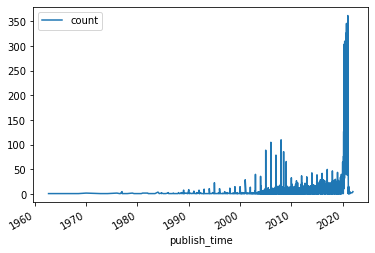

In [44]:
df_publish_time_counted.plot(x ='publish_time', y='count', kind = 'line')
plt.show()

Due to this plot, several observations are created. 

<ul>
  <li>The publications are starting from the 1960s which means that there were already other SARS-viruses under the investigation of researchers. </li>
  <li>The plot shows four swings with an varying extent. 
      Therefore, the four major swings can be affiliated with corresponding SARS-pandemics. 
  <ol>
      <li>~1995 </li>
      <li>~2001</li>
      <li>2005-2010</li>
      <li>2020</li>
  </ol>
  </li>
  <li>The extent of the swings seem to have a relationship accordingly to the impact of the occuring pandemic. More widespread and global SARS outbreaks seem to reflect with a hight count of publications. Whereas, regional and smaller outbreaks are refelected with less publications. </li>
</ul>

For further investigation, the next plot will be target the last two decades. 

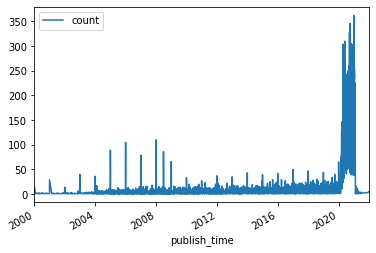

In [45]:
df_publish_time_counted.plot(x ='publish_time', y='count', kind = 'line', xlim=(pd.Timestamp(2000, 1, 1),pd.Timestamp(2022, 1, 1) ))
plt.show()

In the plot above, two different SARS-outbreak can be seen. In the first decade of this century, the SARS-outbreak seems to had less impact because less research was published. The latest SARS outbreak surpassed previous ones by impact and intensity which can be seen in the next plot. 

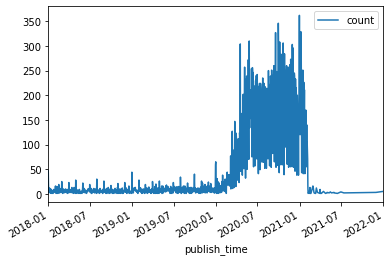

In [46]:
df_publish_time_counted.plot(x ='publish_time', y='count', kind = 'line', xlim=(pd.Timestamp(2018, 1, 1),pd.Timestamp(2022, 1, 1) ))
plt.show()

### Checking the column "journal"

For this inspection, the NaN values of the column journal has to be taken into account. 

In [47]:
find_shared_values(journal)

60166

Most of the values of the column are shared ones. It is important to know that each row of the dataframe is assigned to one journal or none. Thusly, the distributiont of journals will be investigated. 

In [48]:
journal_counted = journal.value_counts()
journal_counted.head(20)

bioRxiv                              2726
PLoS One                             2268
Int J Environ Res Public Health      1154
Sci Rep                               957
Viruses                               613
Virology                              424
BMC Infect Dis                        421
J Med Virol                           394
Arch Virol                            386
Emerg Infect Dis                      383
PLoS Pathog                           356
BMJ Open                              352
medRxiv                               344
Virol J                               333
Front Psychol                         326
Clin Infect Dis                       316
Computational Science - ICCS 2020     296
Int J Mol Sci                         289
Front Immunol                         286
BMC Public Health                     271
Name: journal, dtype: int64

Compared to the other columns, the distribution of journals is to this point the most equally. 

### Checking the column "url"

The column string will be investigated to see which hostnames and its organisations contribute to which extent to this dataset. 

In [49]:
url_counted = url.value_counts()
url_counted

https://doi.org/10.1016/j.joim.2020.10.002; https://www.sciencedirect.com/science/article/pii/S2095496420301084?v=s5; https://api.elsevier.com/content/article/pii/S2095496420301084; https://www.ncbi.nlm.nih.gov/pubmed/33069626/    1
https://www.sciencedirect.com/science/article/pii/S0163445320306381?v=s5; https://www.ncbi.nlm.nih.gov/pubmed/32998038/; https://api.elsevier.com/content/article/pii/S0163445320306381; https://doi.org/10.1016/j.jinf.2020.09.033    1
https://www.ncbi.nlm.nih.gov/pubmed/32235575/; https://doi.org/10.3390/ijerph17072323                                                                                                                                                  1
https://doi.org/10.3390/jcm9092986; https://www.ncbi.nlm.nih.gov/pubmed/32947798/                                                                                                                                                      1
https://doi.org/10.1016/j.ijid.2020.09.029; https://api.elsevier.com

There are entries that contain more than one url pointing to the publication. 
Consequently, entries with more than one url are splitted to a series containing one url per tuple. 

In [50]:
%%time
CORD19_CSV.url = CORD19_CSV.url.str.replace('[;]', '')
url = CORD19_CSV.url
url_list= []
for row in url: 
    row_string = re.split('\s+', row)
    for i in row_string:
        url_list.append(urlparse(i).netloc)
url_list

Wall time: 7.27 s


['arxiv.org',
 'api.elsevier.com',
 'www.sciencedirect.com',
 'api.elsevier.com',
 'doi.org',
 'www.sciencedirect.com',
 'www.ncbi.nlm.nih.gov',
 'www.sciencedirect.com',
 'www.ncbi.nlm.nih.gov',
 'api.elsevier.com',
 'www.ncbi.nlm.nih.gov',
 'doi.org',
 'doi.org',
 'www.ncbi.nlm.nih.gov',
 'onlinelibrary.wiley.com',
 'www.ncbi.nlm.nih.gov',
 'www.ncbi.nlm.nih.gov',
 'doi.org',
 'www.ncbi.nlm.nih.gov',
 'www.ncbi.nlm.nih.gov',
 'doi.org',
 'www.ncbi.nlm.nih.gov',
 'doi.org',
 'www.ncbi.nlm.nih.gov',
 'www.ncbi.nlm.nih.gov',
 'www.ncbi.nlm.nih.gov',
 'doi.org',
 'www.ncbi.nlm.nih.gov',
 'www.sciencedirect.com',
 'api.elsevier.com',
 'www.ncbi.nlm.nih.gov',
 'doi.org',
 'doi.org',
 'www.ncbi.nlm.nih.gov',
 'www.ncbi.nlm.nih.gov',
 'arxiv.org',
 'www.ncbi.nlm.nih.gov',
 'www.ncbi.nlm.nih.gov',
 'doi.org',
 'www.ncbi.nlm.nih.gov',
 'www.ncbi.nlm.nih.gov',
 'doi.org',
 'www.ncbi.nlm.nih.gov',
 'doi.org',
 'www.ncbi.nlm.nih.gov',
 'arxiv.org',
 'www.ncbi.nlm.nih.gov',
 'www.ncbi.nlm.nih.gov'

Next, all urls are counted to see which host publish the research and to which extent. For this, it is important to know that the same publication is accessible via different hosts. 

In [51]:
url_series = pd.Series(url_list) 
url_counted = url_series.value_counts()
url_counted.head(20)

www.ncbi.nlm.nih.gov       64918
doi.org                    54410
www.sciencedirect.com      17660
api.elsevier.com           17660
medrxiv.org                 4995
arxiv.org                   3340
europepmc.org                313
academic.oup.com             118
www.cell.com                  46
link.springer.com             42
onlinelibrary.wiley.com       36
www.nature.com                23
jvi.asm.org                   16
www.jbc.org                   14
journals.iucr.org             14
www.thelancet.com              8
pubs.acs.org                   7
www.tandfonline.com            6
www.biorxiv.org                4
www.ajicjournal.org            3
dtype: int64

As a result, the The National Center for Biotechnology Information (NCBI) is responsible for almost all publications. This means that the publications are hosted by different organisation holding and securing the research as possible backup. 

### Checking the column "software"

The analysis of the column software is conducted in the Jupyer Notebook named "CORD-19-software-counting-cs5099"